# Machine Learning

In this module we will see:

0. predictive models
1. classification
    1. logistic regression
    2. evaluation of classifiers
    4. multiclass classification
4. data transformations
5. overfitting
6. regularization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.patches import Patch
import seaborn as sns
import scipy.signal as spsg
from utils import plot_cv_objects

sns.set_context('talk')  # draws big plots
sns.set_palette('Set1')  # set the colormap for all plots

## Predictive models general framework
We are given some data points (or _samples_)

$x_1, x_2, \dots, x_N$

where each sample $x_i$ is a vector with $D$ _features_.

All samples are usually arranged in a, so called, _design matrix_ with samples on the raws and features on the columns:

$$
X = 
\begin{bmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,D} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,D} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{N,1} & x_{N,2} & \cdots & x_{N,D} 
\end{bmatrix}
$$

We are also given a _label_ for each sample 

$y = [y_1, y_2, \dots, y_N]$

The goal is to build a model that, given a new sample from the population $x_i$ predicts as good as possible the label $y_i$.
The focus on prediction has important consequences for the evaluation of models as we will see shortly.

When the labels $y$ are continuous we have regression models, while when they are categorical we build classification models.


## Classification

In classification problems each sample $x_i$ is assigned to one class $C_k$. 
The (Bayes-)rational approach is to choose the class $C_k$ for which $p(C_k|x_i)$ is maximum.

### Logistic regression
This conditional probability cannot be calculated directly so a common approach is to assume a model for this probability. As usual we start with a linear model: 

$p(C_k|x) = \sigma(w^T x)$, where $\sigma$ is the logistic sigmoid function $\sigma(a) = \frac{1}{1+exp(-a)}$.

where $w$ is a vector of $D+1$ real coefficients (I follow the practice of absorbing the intercept into the vector $w$); thus the sigmoid function acts on a linear combination of the features of $x$. Due to the non linear function $\sigma(a)$ the model is actually not linear in the input $x$ or in the parameters $w$. However  

This model is called logistic regression. The name might sound confusing but if you think about it the model is actually just estimating the continuous probability $p(C_k|x)$; in order to classify we need to fix a value for $p(C_k|x)$ as a decision rule that is independent of the model.
Choosing the class that maximizes $p(C_k|x)$ is equivalent to fixing the decision rule at $p(C_k|x)=0.5$; this is a valid strategy only when the utility of each choice is equal. For example in a scenario of threat detection you generally place a higher cost on misses than on false alarms. But let's stick here to the simple case.

The reason why we call this a linear model for classification is that the decision boundary is linear in feature space (which is easily realized by noting that the boundary has equation $p(C_k|x) = \sigma(w^T x) = constant$ and this occurs when $w^T x = constant$).

The parameters $w$ are estimated by minimizing the (cross-entropy) error function (which arises from maximum-likelihood):
$$ E(w)= - \sum_i^N y_i ln\hat{y}_i + (1-y_i) ln(1-\hat{y}_i)$$

where $\hat{y}_i = \sigma(w^T x_i)$. I'm not entering into the details of the optimization but since the error function is concave there is only one minimum and efficient iterative methods can be used.

> __Note on other classification models__ 

>Other classifiers model the class conditional probability $p(x|C_k)$ and the prior class probability $p(C_k)$ and then use Bayes theorem to calculate the posterior class probability. Models of this family are for example _linear_ and _quadratic discriminant analysis_ and _naive Bayes_. In practice this classifiers have more parameters to estimate than simple linear regression and give poorer results when the assumptions behind their models are not met.

In order to understand how this model works, let's make up some data for classification:

In [230]:
def make_2Dclass(N=50, s1=1, s2=1, d=3):
    """ creates simple bidimensional data """
    Nhalf = int(N/2)
    x1 = np.random.randn(Nhalf, 2)*[s1, s2]
    x2 = np.random.randn(Nhalf, 2)*[s1, s2] + d
    X = np.vstack([x1, x2])
    y = np.array([0 if i<Nhalf else 1 for i in range(N)])
    return X, y

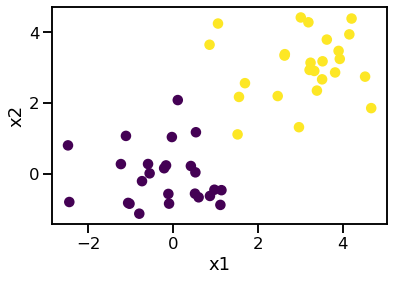

In [231]:
X, y = make_2Dclass(s1=1, s2=1, d=3)
# plot data
cm = plt.cm.RdBu
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Now we can use scikit-learn library to implement a logistic regression model.

In [232]:
# define model
model = LogisticRegression(solver='lbfgs')

All scikit-learn model have a `fit()` method that allows to estimate their parameters. Since logistic regression is part of what is called __supervised learning__ we need to pass both X and y as parameters to `fit(X, y)`.

>__Supervised learning__ is a family of algorithm that uses information in the labels in order to estimate model's parameters; supervised methods are usually applied to classification and regression.

>__Unsupervised learning__, guess it, only uses information in $X$ to estimated model's parameters; typical tasks for unsupervised algorithms are clustering and dimensionality reduction.


In [233]:
# estimate parameters
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

We can also draw the boundary (since this is just 2D) and see how was the parameters estimation.

Since this is a linear model we know that the boundary is going to be a line with equation $u = \frac{w_1}{w_2} x_1 - \frac{w_0}{w_2}$, where $w$ is the vector of estimated coefficients and $w_0$ is the intercept.

Once a model has been fitted we can inspect the fitted coefficients through `coef_` and `intercept_` attributes (trailing underscore is the convention of scikit-learn for attributes that have been estimated).

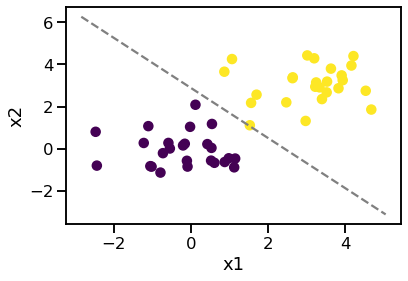

In [234]:
w = model.coef_[0]
xx = np.array([ax.get_xlim()[0], ax.get_xlim()[1]])
u = -w[0] / w[1] * xx - model.intercept_[0] / w[1]
plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o')
plt.plot(xx, u, '--', color='grey')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

You can play around creating data with different variance and different separation and see how the estimation is affected.

However when we talk about predictive models we usually want models that are able to make predictions for __new data__ that have not been used to estimate model's parameters, or in other words we want our model to be valid for the __population__ not only for the finite sample we have.

Since these are simulated data we can draw more samples and calculate the accuracy on these samples with model's parameters fixed.
This is achieved with `score()` method.

In [235]:
Xnew, ynew = make_2Dclass(N=100000, s1=1, s2=1, d=3)
print("acccuracy on new data: %.2f" %model.score(Xnew, ynew))

acccuracy on new data: 0.98


With real data we can't usually sample more points, so we need a procedure to test the accuracy of models for new samples (also called generalization accuracy) using only the data that we have.

### Classifiers evaluation

#### Training set has to be separated from test set

The data that we use to estimate model's parameters is called __training set__, so `X, y` above is our training set.

__test set__ is data that are only use to estimate prediction accuracy, `Xnew, ynew` above is our test set. 

What we want to know is how good the classifier is in predicting the class for the whole population, i.e. for future samples. 

So we have to evaluate the classifier on data that have not been used for training.

This means that we have to separate the available data in two sets: one for training and the other for testing. The collection of techniques to separate data to evaluate prediction accuracy is called __cross-validation__.

The simplest way would be to split the samples in two sets, for example take the first 20% of samples for the test set and the rest for training.

In [236]:
N = X.shape[0]  # number of samples
n_test = int(N*0.2)  # num of samples for test set
# split the data
Xtest, ytest = X[:n_test, :], y[:n_test]
Xtrain, ytrain = X[n_test:, :], y[n_test:]
model.fit(Xtrain, ytrain)
print("test acccuracy: %.2f" %model.score(Xnew, ynew))

test acccuracy: 0.97


#### Shuffle and split

The estimate of classification error based on this split will be slightly different depending on which samples are in the training and test set (at least for small/medium datasets).
We can repeat the split with different samples using __random permutations cross-validation__. With this method we leave out a random selection of samples of a given size `test_size` for the test set and use all other samples for training. This procedure can be repeated many times. The method is also called __shuffle & split__, since data can be first shuffled and then split into training and test set.

The advantage with respect to k-fold CV is that here the number of splits and test set size are decoupled: we can repeat the splitting as many times as we want independently of the number of samples used for training and testing.

In the following code I used scikit-learn class `ShuffleSplit` that implements random permutation CV. Now we have `repetitions` splits, so instead of just summarizing the accuracy with its median or mean we can have a look at its distribution using a violing plot implemented in seaborn library. When the accuracy approaches the extremes of 1 or chance level the distribution gets very skewed.

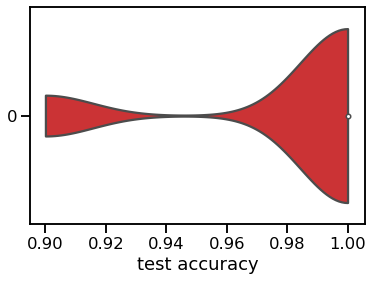

In [237]:
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i += 1

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score], cut=0, orient='h', scale='width', ax=ax)
ax.set_xlabel('test accuracy')
plt.show()

#### How good is the obtained accuracy?

In order to answer this question we need to compare our accuracy with that expected by chance, i.e. by purely guessing the prediction.

In a simple case if we have two classes with the same number of elements we know that by guessing we are going to right 50% of the times (we can even estimate the variance of random guessing strantegy modelling it as a Binomial distribution).

As an alternative, that also works in more complicated scenarios, we can shuffle the labels in `y`, thereby destroying the relation between `X` and `y`, and train another classification model on this shuffled data. The resulting test accuracy will be that expected by chance.

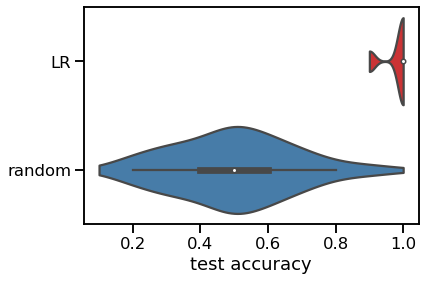

In [238]:
# instantiate a model for random guessing
model_rnd = LogisticRegression(solver='lbfgs')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
ax.set_xlabel('test accuracy')
plt.show()

#### Unbalanced classes

When we have unbalanced classes the expected number of correct random guesses is higher.

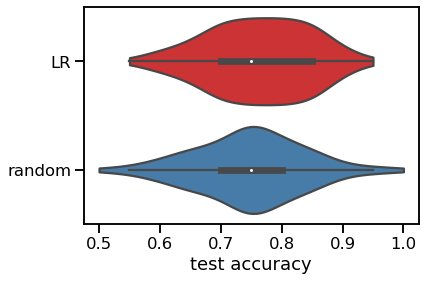

In [239]:
# create data with 80% of samples in one class
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.8, 0.2], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
# instantiate a model for random guessing
model_rnd = LogisticRegression(solver='lbfgs')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
ax.set_xlabel('test accuracy')
plt.show()

#### CV for grouped observations

Often in neuroscience data are collected multiple times from the same subject. This applies to many fields beyond neuroscience and is usually called _within subject_ or _repeated measures design_. For example this happens in longitudinal studies, where the same patient is tested multiple times to monitor the development of a disease.

In such situations there is an additional grouping beyond that of the classes you want to predict. This grouping usually consititutes another source of variability in the data.Using standard permutation CV, samples from the same group (or subject) will fall in the training and test set; if samples from the same group are similar to each other the training and test set will be similar and in turn the test accuracy will be inflated.

In such situation we usually want to make predictions that are valid also for new groups that we have not observed (not for the specific groups that have been measured). Then we should mimic this condition in the CV procedure.
This type of CV routines are generally called __CV for grouped observations__. The general idea is to leave some groups out of the training set and use them only for the test set.

The following code graphically illustrates the difference between the two CV strategies. For grouped data scikit-learn implements a CV class `GroupShuffleSplit` that randomly samples groups for the test set and uses the rest for the training.

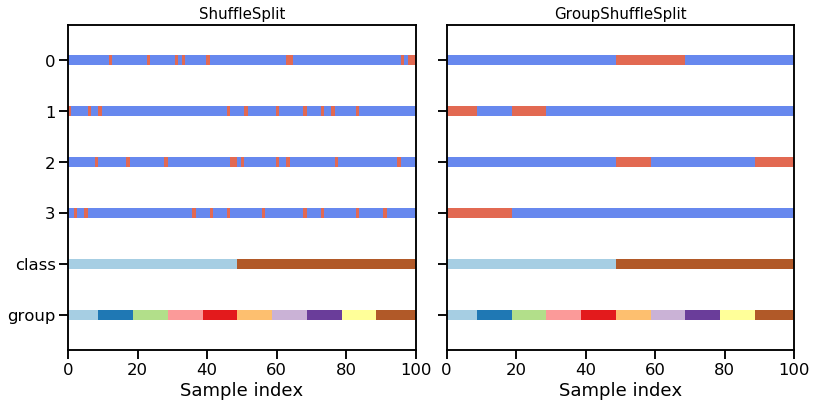

In [240]:
plot_cv_objects()

### <font color="blue"> Exercises

1. change the separation between the two classes in order to see how it affects the classification performance
2. increase the number of samples. How does it affect the classification? (use make_classification() to generate data).
3. increase the number of dimension for the data. How is the accuracy affected? How many samples do you need to get the same level of accuracy?
4. try different proportions of samples for each class to see how the inbalance affects the classifcation (through a confusion matrix)
5. show the confusion matrix for the test set of one cross-validation fold.
6. $\star$ show the average confusion matrix for the test set over all folds.
7. modify the code of confusion matrix to show the proportion of samples with respect to the number of samples in each class.

### Multiple classes

Until now we only worked with binary classification but many interesting problems have several classes. For example distinguishing AD from MCI and controls or characterizing different cognitive tasks or identifying individual subjects (brain-fingerprinting).

Every binary classifier can be used to classify samples from multiple classes by transforming a problem with $k$ classes in $k$ binary classification of one class against all the rest of classes. Unexpectedly this method is called _one versus the rest_.

Some classifiers however are natively multiclass, like kNN and don't need to rely on one-versus-rest heuristics. Logistic regression has its multiclass version, _multinomial_ logistic regression, where the logistic sigmoid is replaced by the __softmax function__ $\psi(a_i) = \frac{exp(a_i)}{\sum^k_j exp(a_j)}$.

When we have multiple classes the most useful tool for the assessment of model's performance is the confusion matrix, where in each entry $C_{i,j}$ we have the proportion of samples from class $i$ predicted by the model as class $j$.. Indeed, as you can see in the following code, the confusion matrix immediately informs us about any inbalance in the accuracy. In practive you will often observe that some class is particularly difficult or particularly easy to predict.

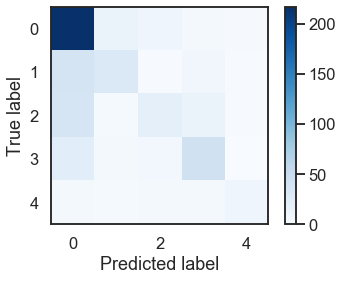

In [241]:
# create data with multiple classes
X, y = make_classification(n_samples=500, n_features=10, n_informative=10,
                           n_redundant=0, n_repeated=0, n_classes=5,
                           weights=[0.5, 0.15, 0.15, 0.15, 0.05], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i += 1

CM = confusion_matrix(y_true=y, y_pred=model.predict(X))
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

For binary classification the confusion matrix represents so called hits and misses. 
For example, the error of classifying a threat as non-threat (or cancer as non-pathological) is called a __miss__ or __type II error__.
Classifying a normal medical image as cancer is called a __false alarm__ or __type I error__.

## Data transformations

Until now we have seen simple classification based on "raw" data. Actually it is common to apply some transformations to data in order to boost the performance of the classifier.

Typical transformations for general applications include (but are not limited to) normalization and dimensionality reduction. But if you think about neuroscience also calculating the functional connectivity is a kind of transformation: you are given time series and you transform them into a connectivity matrix. Even before that parcellating the signals is a kind of transformation.

Many transformation involve some parameter fitting (estimation of EC, functional parcellations, standardization).

__WARNING__: It's very important that, if the estimation of parameters need to use information from multiple samples, the only samples used are those from the training set (not the whole dataset). Always remember that you are not supposed to have access to the test set until the training of your predictive model is done, you can think about the test set as data that will be aquired in the future; so, using the test set for estimating any transformation is like __looking into the future__.

So, for example, if you use a functional parcellation that estimate clusters of time series over all subjects, you need to estimate the clusters only using the subjects from the training set and then apply the clustering to the subjects of the test set. 

As an example, here we see how to perform a simple standardization of data (which is useful when features have different scales).

> If you need to perform data transformations scikit-learn has a nice mixin class `TransformerMixin` that allows to easily create transformers (I'm not covering this but you can read more in scikit-learn docs).

In the following code we compare a raw dataset with its standardized version. In order to standardize data we use scikit-learn `StandardScaler` class, that is a transformer, thus it implements a `transform()` method.

In [242]:
X, y = make_2Dclass(N=50, s1=.1, s2=40, d=.4)
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

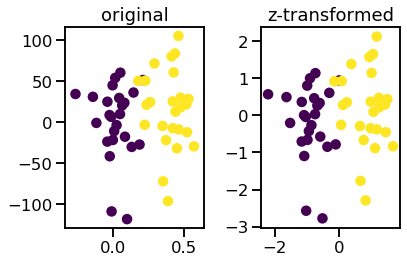

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X[:, 0], X[:, 1], c=y, marker='o')
ax[0].set_title('original')
ax[1].scatter(Xscaled[:, 0], Xscaled[:, 1], c=y, marker='o')
ax[1].set_title('z-transformed')
plt.tight_layout()

Scikit-learn implements the concept of a pipeline to connect several estimators in the class `Pipeline`, which are as you can imaging objects that make some estimation. You can connect as many transformers as you wish in a pipeline and the last step may be a transformer or a classifier.

In the following code we build a pipeline with a `StandardScaler` and `LogisticRegression` model and compare the classification accuracy with that of the simple logistic regression.

Notice that estimating parameters for the z-score only on training set and applying them to transform the test set is done by the pipeline under the hood: when we call the `fit()` method of the pipeline we only pass the training set and all the parameters in the pipeline are estimated only using these data.

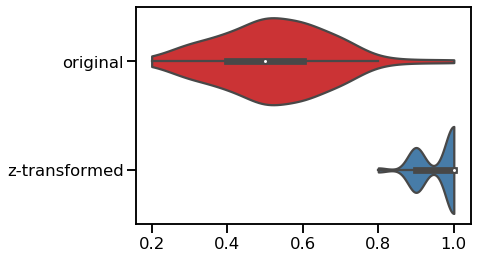

In [244]:
model = LogisticRegression(solver='lbfgs')
pipe = Pipeline([('clf', model)])
pipeS = Pipeline([('zscore', StandardScaler()), 
                         ('clf', model)])
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)

score = np.zeros([repetitions])
scoreS = np.zeros([repetitions])
i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    pipe.fit(X[train_idx, :], y[train_idx])
    pipeS.fit(X[train_idx, :], y[train_idx])
    score[i] = pipe.score(X[test_idx, :], y[test_idx])
    scoreS[i] = pipeS.score(X[test_idx, :], y[test_idx])
    i+=1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, scoreS], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['original', 'z-transformed'])
plt.show()

Beyond allowing to show the usefulness of `Pipeline` this example also shows the importance of scaling features when they are not homogeneous: __if a non informative feature has large variance you are going to have poor accuracy__.

## Overfitting

When models are too complex (too many degrees of freedom) compared to the constraints imposed by data they tend to _overfit_, i. e. perfectly adjust to the training data, thereby fitting the noise, which in turn produces low performance on new data (where the noisy realizations are different).

In practice if you get a poor prediction accuracy it's not easy to tell if your model is wrong or if you are overfitting data.

In order to distinguish the two cases you should compare training and test accuracy. In extreme cases things are clear: we get zero error on the training set (the model perfectly predicts the training set) and higher error on the test set. But sometimes we get such a clear picture, however when the test accuracy is substantially higher than training accuracy there might be some overfitting.

### Overfitting in high dimensions

Overfitting is often observed when the data have many dimensions (which is a common situation in neuroscience), compared to the number of samples.

If you think about a logistic regression, this model is going to fit one coefficient for each dimension, so it's going to have many degrees of freedom.

Notice that 3 points in 2D space are always linearly separable (and more in general N points in the N-1 dimensional space). To get an intuition of why complex models are bad you can think about the process of doing a polynomial regression adding many terms: at some point the polynomial has enough degrees of freedom to exactely pass through all the points but it's not capturing the true relation in the data. Something similar happens when your data have too many dimensions.

We see it in practice in the following code.

In [245]:
D = 100
X, y = make_classification(n_samples=100, n_features=D, n_informative=max(2, int(D/10)),
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=.8, random_state=None)
clf = LogisticRegression(solver='liblinear', C=100000, penalty='l1')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_train = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    clf.fit(X[train_idx, :], y[train_idx])
    score[i] = clf.score(X[test_idx, :], y[test_idx])
    score_train[i] = clf.score(X[train_idx, :], y[train_idx])
    i += 1

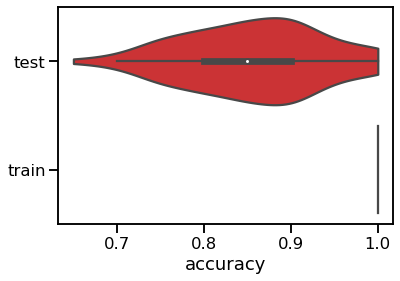

In [246]:
# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, score_train], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['test', 'train'])
ax.set_xlabel('accuracy')
plt.show()

## Regularization

Regularization is a family of techniques to reduces the complexity of a model and so avoid overfitting.

For logistic regression we can obtain a regularized estimation by simply adding a penalty term to the error function $E(w)$.

$$E_{reg}(w) = E(w) + \lambda ||w||_q$$

where $||w||_q = (\sum^D_j(w_j^q))^{\frac{1}{q}}$ is the q-norm of the weights vector and $\lambda$ is a scalar penalty parameter. In practice only 1- and 2-norm are used.

As you can intuitively see a high value of $\lambda$ will push all coefficients in $w$ to zero (since we are minimizing the error function. If $\lambda=0$ we recover the unregularized estimation. The difference between 1- and 2-norm is only the speed at which coefficients are pushed to zero, thus 1-norm promotes sparser solutions (more coefficients are estimated as zero) than 2-norm.

In the following code we can compare an L2-regularized logistic regression with the unregularized one. 
Here we are using 1-norm since we know that many features are not informative at all. Scikit-learn implementation uses parameter `C` which correspond to $1/\lambda$). 

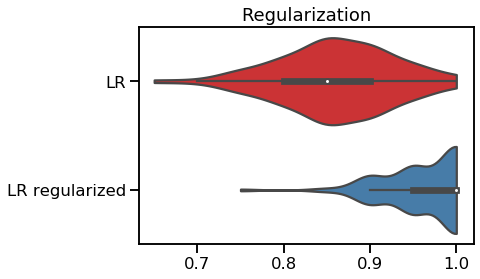

In [247]:
clfreg = LogisticRegression(C=.1, penalty='l1', solver='liblinear')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
scorereg = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    clf.fit(X[train_idx, :], y[train_idx])
    score[i] = clf.score(X[test_idx, :], y[test_idx])
    clfreg.fit(X[train_idx, :], y[train_idx])
    scorereg[i] = clfreg.score(X[test_idx, :], y[test_idx])
    i += 1

# plot comparison as violin plots
fig, ax = plt.subplots()
sns.violinplot(data=[score, scorereg], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'LR regularized'])
ax.set_title('Regularization')
plt.show()

### <font color="blue"> Exercises

1. try different values of the penalty parameter $C$.
2. vary the number of features.
3. try L1 or L2 regularization.

## Classification with brain connectivity

Now we are able to put together the tools from blocks 1 and 2 (for the estimation of functional or effective connectivity) with those learned in this block.

To show it let's load some data.
We are loading the movie dataset that you have already seen in block 2.


shape of data array: (22, 5, 66, 300)


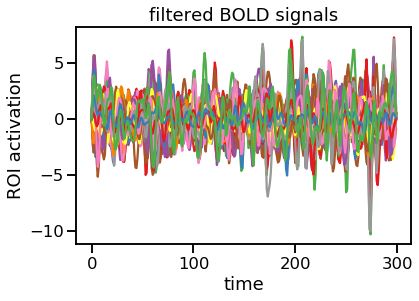

In [6]:
######################
# fMRI data properties    
n_sub = 22 # number of subjects
n_run = 5 # number of sessions/runs: 2 rest + 3 movie
N = 66 # number of ROIs
T = 300 # number of TRs for each session


#################
# functional data
ts_emp = np.load('../movie_data/ts_emp.npy')
print('shape of data array:', ts_emp.shape)

# filtering between 0.01 and 0.1 Hz
n_order = 3
Nyquist_freq = 0.5 / 2. # time resolution (TR) for fMRI = 2 seconds
low_f = 0.01 / Nyquist_freq
high_f = 0.1 / Nyquist_freq
b, a = spsg.iirfilter(n_order, [low_f, high_f], btype='bandpass', ftype='butter')

filtered_ts_emp = spsg.filtfilt(b, a, ts_emp, axis=-1)

# plots
plt.figure()
plt.plot(range(T), filtered_ts_emp[0, 0, :, :].T)
plt.xlabel('time')
plt.ylabel('ROI activation')
plt.title('filtered BOLD signals');

As you have seen in block 1, we can calculate the functional connectivity based on Pearson's correlation from time series for all subjects and runs.

Next code show just shows one example FC matrix.

Instead of Pearson's correlation you can also try covariance, precision, partial correlation or effective connectivity estimated with MOU model.

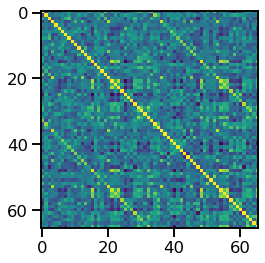

In [7]:
FC = np.zeros([n_sub, n_run, N, N])
for i_sub in range(n_sub):
    for i_run in range(n_run):
        FC[i_sub, i_run, :, :] = np.corrcoef(filtered_ts_emp[i_sub, i_run, :, :])

plt.figure()
plt.imshow(FC[0, 0, :, :]);

Now we want to use the entries of the FC matrix as features for classification.
In a correlation matrix there are only $N(N-1)/2$ independent entries.
For each subject and run we take all these entries, vectorize them and stack them together to form the design matrix `X`.

Labels for the classification can be the identity of subjects or the identity of runs (two rest sessions and three movie sessions with different parts of the movie).

In the following we show runs classification but you can also try to identify the subjects.

In [28]:
n_tril = int(N * (N-1) / 2)
X = np.zeros([n_sub * n_run, n_tril])
y_movrest = np.zeros(n_sub * n_run)
y_sub = np.zeros(n_sub * n_run)
i = 0
for i_sub in range(n_sub):
    for i_run in range(n_run):
        thisFC = FC[i_sub, i_run, :, :]
        X[i, :] = thisFC[np.tril_indices(N, k=-1)]
        y_movrest[i] = i_run
        y_sub[i] = i_sub
        i += 1

print('shape of design matrix:', X.shape)

shape of design matrix: (110, 2145)


Now that we have our design matrix and labels vector we can right down the code for classification using all the steps we have learned in this block.
1. let's compare regularized and standard model
2. use a z-score (and `Pipeline`) to be sure all features have the same scale
3. use CV for grouped observations since subjective identity induces an additional grouping

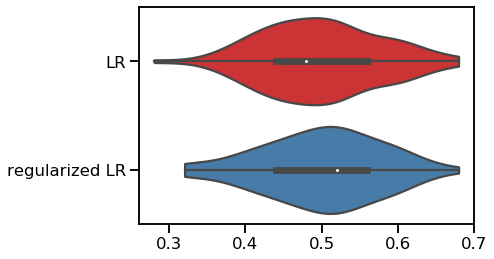

In [33]:
model = LogisticRegression(C=100000, penalty='l2', solver='newton-cg', multi_class='ovr')
modelreg = LogisticRegression(C=1, penalty='l2', solver='newton-cg', multi_class='ovr')
pipe = Pipeline([('zscore', StandardScaler()), 
                         ('clf', model)])
pipereg = Pipeline([('zscore', StandardScaler()), 
                         ('clf', modelreg)])
repetitions = 100
shS = GroupShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)

score = np.zeros([repetitions])
scorereg = np.zeros([repetitions])
i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X, groups=y_sub):  # repetitions loop
    pipe.fit(X[train_idx, :], y_movrest[train_idx])
    pipereg.fit(X[train_idx, :], y_movrest[train_idx])
    score[i] = pipe.score(X[test_idx, :], y_movrest[test_idx])
    scorereg[i] = pipereg.score(X[test_idx, :], y_movrest[test_idx])
    i+=1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, scorereg], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'regularized LR'])
plt.show()

Since this is a multiclass classification we can also look at the confusion matrix to see if we get some insight.

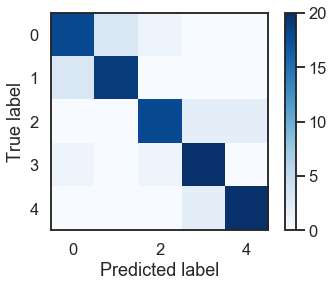

In [34]:
CM = confusion_matrix(y_true=y_movrest, y_pred=pipereg.predict(X))
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()